# Using JATIC's Image Classification Protocol with `xaitk-saliency`

This is a simple notebook demonstrating how classifiers based on JATIC's image classification protocol can interface with `xaitk-saliency`.

## Table Of Contents
* [Environment Setup](#environment-setup)
* [Example Image](#example-image)
* [Instantiate Protocol-Based Classifier](#instantiate-protocol-based-classifier)
* [Transform Protocol-Based Classifier](#transform-protocol-based-classifier)
* [Use the Classifier as "Normal"](#use-detector-as-normal)
    * [Generate Saliency Maps](#generate-saliency-maps)
        * [Saliency Generation](#saliency-generation)
        * [Display Saliency Maps](#display-saliency-maps)
    

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-jatic...")
!{sys.executable} -m pip install -q xaitk-jatic
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets==2.15.0
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing torch...")
!{sys.executable} -m pip install -q torch
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Done!")

Installing xaitk-jatic...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing torch...
Installing torchvision...
Installing matplotlib...
Done!


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt  # type: ignore

import numpy as np
import time
import torch  # type: ignore
from PIL import Image
from typing import Any, Dict, Hashable, Sequence

from datasets import load_dataset  # type: ignore
from transformers import AutoModelForImageClassification  # type: ignore
from transformers import AutoImageProcessor  # type: ignore

import maite.protocols.image_classification as ic

from xaitk_jatic.interop.image_classification.model import JATICImageClassifier
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack

## Example Image <a name="example-image"></a>

We'll use a single example image from the CIFAR-10 test dataset.

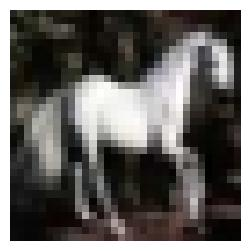

In [3]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

ds = load_dataset("cifar10", split="test")
img = np.asarray(ds[13]["img"])  # type: ignore

plt.figure(figsize=(3,3))
plt.axis('off')
_ = plt.imshow(img)

## Instantiate Protocol-Based Classifier <a name="instantiate-protocol-based-classifier"></a>

First, we need a classifier that uses the image classification protocol. Here we'll be be wrapping a model from Hugging Face, but this could be **any** model that conforms to the image classification protocol!

In [4]:
class HuggingFaceClassifier:
    def __init__(self, model_name: str, device: str):
        self.image_processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModelForImageClassification.from_pretrained(model_name)
        self.device = device

        self.model.eval()
        self.model.to(device)

    def id2label(self) -> Dict[int, Hashable]:
        return self.model.config.id2label

    def __call__(self, batch: ic.InputBatchType) -> ic.TargetBatchType:
        # tensor bridging
        batch = torch.as_tensor(batch)
        assert batch.ndim == 4

        # preprocess
        hf_inputs = self.image_processor(batch, return_tensors="pt")

        # put on device
        hf_inputs = hf_inputs.to(self.device)

        # get predictions
        with torch.no_grad():
            hf_predictions = self.model(**hf_inputs).logits.softmax(1).detach().cpu()
        
        return hf_predictions

jatic_classifier: ic.Model = HuggingFaceClassifier(
    model_name="aaraki/vit-base-patch16-224-in21k-finetuned-cifar10",
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

## Transform Protocol-Based Classifier <a name="transform-protocol-based-classifier"></a>

Now that we have our JATIC protocol-based classifier, we can wrap it so that it can be used directly with `xaitk-saliency`.

In [5]:
classifier = JATICImageClassifier(
    classifier=jatic_classifier, 
    id2name=jatic_classifier.id2label()
)

## Use the Classifier as "Normal" <a name="use-classifier-as-normal"></a>

Now the classifier can be used just like it is a regular `ClassifyImage` implementation with `xaitk-saliency`.

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

We'll generate saliency maps for our selected example using the `SlidingWindowStack` implementation.

In [6]:
sal_generator = SlidingWindowStack(
    window_size=(2, 2), 
    stride=(1, 1), 
    threads=4
)
sal_generator.fill = (128, 128, 128)

In [7]:
print("Generating saliency maps...")
start = time.time()
sal_maps = sal_generator(
    img,
    classifier
)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating saliency maps...
Done in 16.08s


#### Display Saliency Maps <a name="display-saliency-maps"></a>

In [8]:
def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray, labels) -> None:    
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(24, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')
        
    for i, class_sal_map in enumerate(sal_maps):
        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.title(f"Pos Saliency:\n{labels[i]}")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.title(f"Neg Saliency:\n{labels[i]}")
        plt.axis('off')

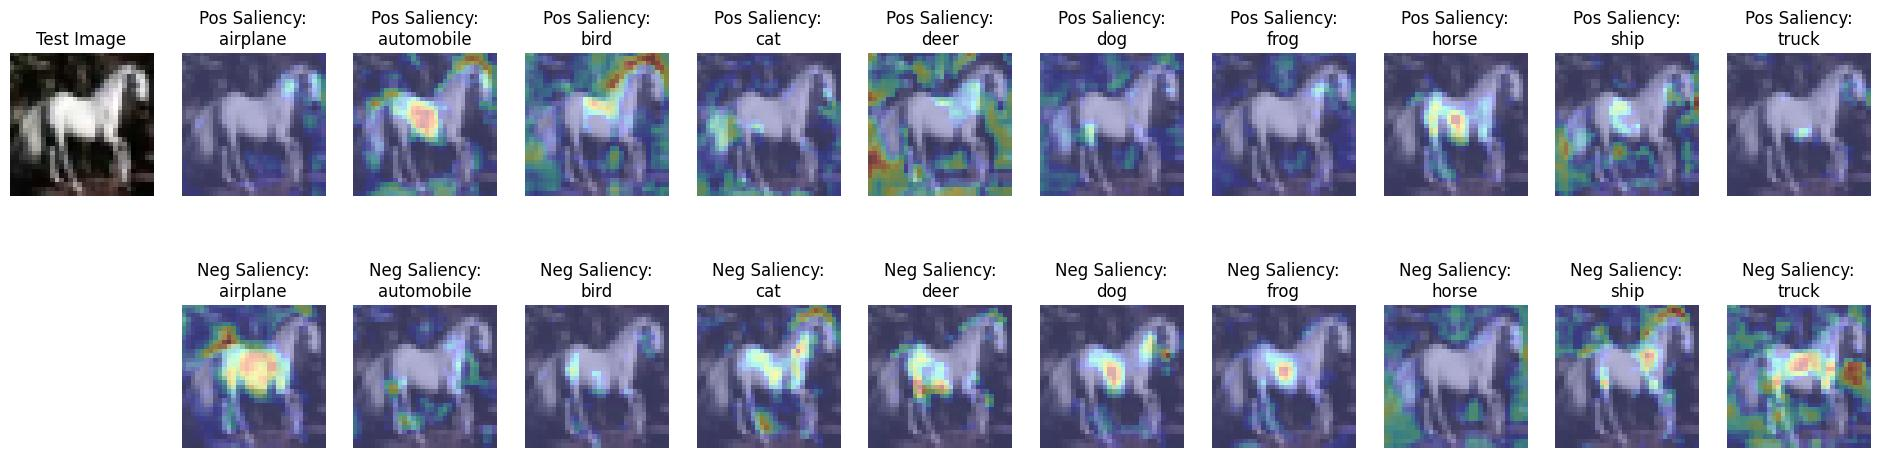

In [9]:
visualize_saliency(img, sal_maps, classifier.get_labels())